In [45]:
import pandas as pd
import numpy as np
from contextualbandits.online import LinUCB
from sklearn.preprocessing import StandardScaler

# === 1. Load and prepare data ===
df = pd.read_csv("../data/Xy_train_resampled.csv")

# assuming last column is 'num'
X = df.drop(columns=['num']).values
y = df['num'].astype(int).values

# scale features (recommended for LinUCB)

# === 2. Initialize contextual bandit policy ===
n_actions = len(np.unique(y))  # should be 5 (0–4)
policy = LinUCB(nchoices=n_actions, alpha=0.3)

# === 3. Simulate online learning ===
preds, rewards = [], []

for i in range(len(X)):
    x_i = X[i].reshape(1, -1)  # needs 2D input
    true_label = y[i]

    # Predict (returns action indices)
    chosen_action = policy.predict(x_i)[0]

    # Reward: 1 if correct, else 0
    reward = int(chosen_action == true_label)

    # Update policy with this sample
    policy.partial_fit(x_i, np.array([chosen_action]), np.array([reward]))

    preds.append(chosen_action)
    rewards.append(reward)

# === 4. Store results ===
results = pd.DataFrame({
    "true_label": y,
    "predicted": preds,
    "reward": rewards
})

print("✅ Simulation complete")
print(f"Approx. accuracy: {np.mean(results['true_label'] == results['predicted']):.3f}")


✅ Simulation complete
Approx. accuracy: 0.507


In [28]:
results

,true_label,predicted,reward
0,3,1,0
1,0,3,0
2,2,3,0
3,1,0,0
4,1,1,1
...,...,...,...
1640,4,4,1
1641,4,4,1
1642,4,4,1
1643,4,4,1


In [29]:
n_actions

5

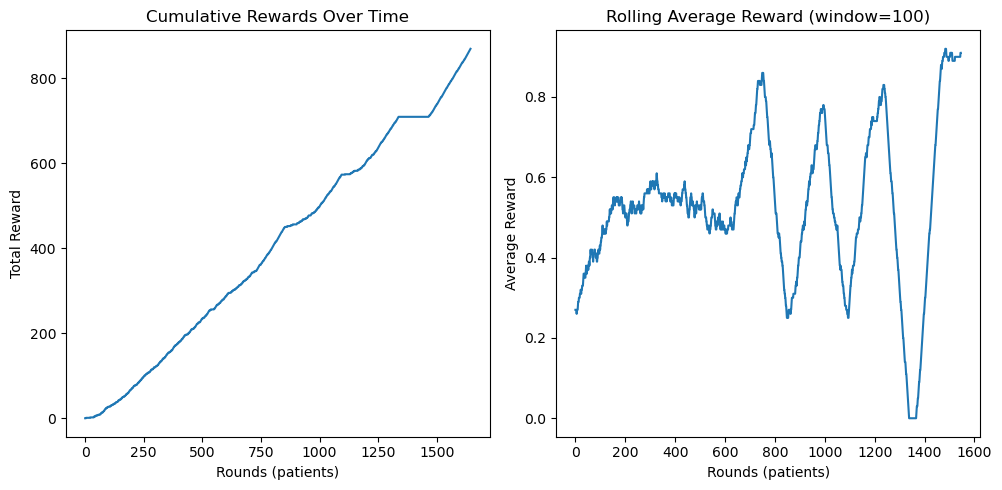

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `bandit` is your trained model and you used something like:
# results = bandit.fit_predict(X, y)
# or evaluate(X, y)

# If you already have your true labels and predictions:
rewards = (preds == y).astype(int)  # 1 = correct prediction, 0 = incorrect

# Cumulative rewards over time
cumulative_rewards = np.cumsum(rewards)

# Rolling average reward (for smoother curve)
window = 100
rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Time")
plt.xlabel("Rounds (patients)")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(rolling_avg)
plt.title(f"Rolling Average Reward (window={window})")
plt.xlabel("Rounds (patients)")
plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()



In [31]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

# Load your dataset and predictions
df = pd.read_csv("../data/Xy_train_resampled.csv")

# Add model predictions (assuming `preds` is a numpy array)
df["pred"] = preds  # from your trained bandit model
df["true"] = df["num"]  # ground truth target

# Protected attribute
protected_attr = "sex"
groups = df[protected_attr].unique()

metrics = {}
for g in groups:
    group_df = df[df[protected_attr] == g]
    acc = accuracy_score(group_df["true"], group_df["pred"])
    rec = recall_score(group_df["true"], group_df["pred"], average="macro")  # across all 5 classes
    metrics[g] = {"accuracy": acc, "recall": rec}

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


KeyError: 'sex'